# this notebook is for binning error bars to a fixed resolution

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from binning import bin_err, white_light_curve

In [2]:
pandexo_errs = np.loadtxt('./pandexo_output/pandexo_errs.txt').T
pandexo_errs_25 = np.loadtxt('./pandexo_output/pandexo_errs_25.txt').T

In [3]:
x, y, e = pandexo_errs           # native instrument resolution (still haven't figured out)
x25, y25, e25 = pandexo_errs_25  # pandexo R = 25

### For reference, here are the error curves produced with Pandexo. I'm trying to take the unbinned pandexo errors (black) and bin them myself, and it should match pandexo's $R = 25$ binned errors (blue).

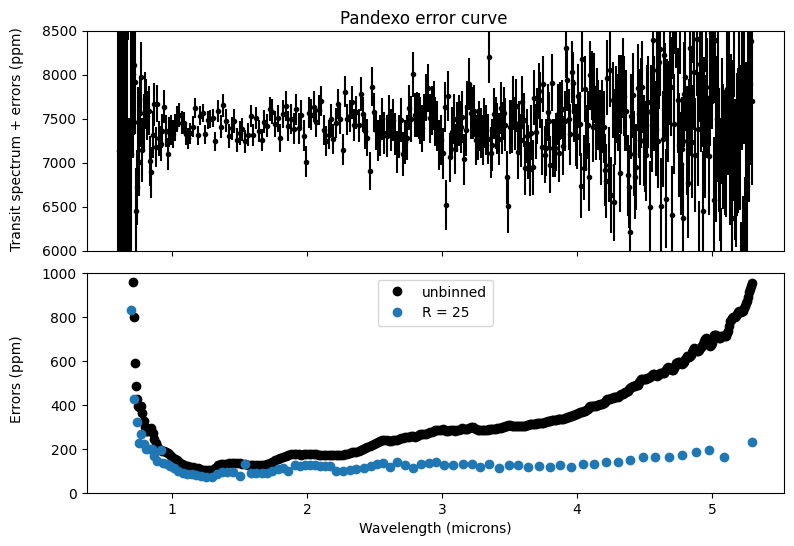

In [4]:
fig, axs = plt.subplots(2, 1, figsize = (9,6), sharex = True)
fig.subplots_adjust(hspace = 0.1)

axs[0].errorbar(x, y, e, fmt = '.', c = 'black')
axs[1].plot(x, e, 'o', label = 'unbinned', c = 'black')
axs[1].plot(x25, e25, 'o', label = 'R = 25')

axs[0].set_ylim(6000,8500)
axs[1].set_ylim(0, 1000)

# Labels
fig.suptitle('Pandexo error curve', y = 0.915)
fig.text(0.04, 0.3, 'Errors (ppm)', va='center', rotation='vertical')
fig.text(0.04, 0.7, 'Transit spectrum + errors (ppm)', va='center', rotation='vertical')
axs[1].set_xlabel('Wavelength (microns)')
axs[1].legend()
plt.show()

### Using my binning function to bin to resolution R, and then comparing to Pandexo

In [5]:
R = 50
new_wave, new_errs, dellambs = bin_err(x, e, R)

In [6]:
# gonna plot x errbars on Pandexo R25 errors to see if they don't overlap
#pandexo25_bin_widths = calc_bin_widths(x25, R = 25)
#pandexo_bin_widths = calc_bin_widths(x, R = 100)

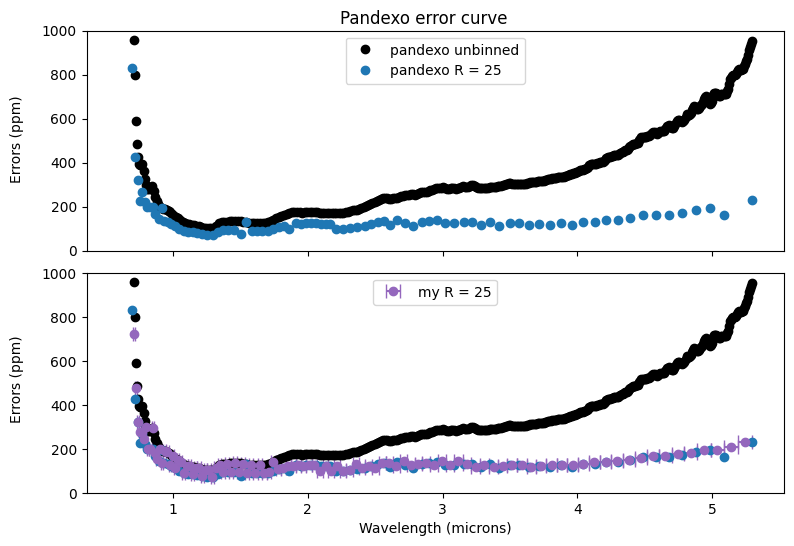

In [7]:
fig, axs = plt.subplots(2, 1, figsize = (9,6), sharex = True)
fig.subplots_adjust(hspace = 0.1)

axs[0].plot(x, e, 'o', c = 'black', label = 'pandexo unbinned')
axs[0].plot(x25, e25, 'o', c = 'tab:blue', label = 'pandexo R = 25')
axs[0].set_ylim(0, 1000)
axs[0].legend()

# need to half the bin widths for errobar plotting
axs[1].errorbar(x25, e25, None, None, 'o', capsize = 5, c = 'tab:blue')
axs[1].errorbar(new_wave, new_errs, None, np.array(dellambs)/2, 'o', capsize = 5, c = 'tab:purple', label = 'my R = 25')
axs[1].plot(x, e, 'o', c = 'black')

axs[1].set_xlim
axs[1].set_ylim(0, 1000)
axs[1].set_xlabel('Wavelength (microns)')
axs[1].legend(loc = 'upper center')

# Labels
fig.suptitle('Pandexo error curve', y = 0.915)
fig.text(0.04, 0.3, 'Errors (ppm)', va='center', rotation='vertical')
fig.text(0.04, 0.7, 'Errors (ppm)', va='center', rotation='vertical')
plt.savefig('pandexobinsvsmybins.png')
plt.show()

In [8]:
len(new_wave)

109

In [9]:
len(x25)

93

In [10]:
len(x)

403

In [11]:
plt.figure(figsize = (9,4))

# need to half the bin widths for errorbar plotting
plt.errorbar(x25, e25, None, np.array(pandexo25_bin_widths)/2, 'o', c = 'tab:blue', label = 'pandexo R = 25')
plt.errorbar(new_wave, new_errs, None, np.array(dellambs)/2, 'o', capsize = 1, c = 'tab:purple', label = 'my R = 25')
plt.plot(x, e, 'o', c = 'black', label = 'pandexo unbinned')

# Axes limits
#plt.xlim(2,3)
plt.ylim(0, 350)

# Labels
plt.title('Pandexo error curve')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Error (ppm)')

plt.legend()
plt.show()

NameError: name 'pandexo25_bin_widths' is not defined

<Figure size 900x400 with 0 Axes>

### checking if the bin spacing increases with wavelength as expected

In [ ]:
#plt.plot(new_wave, np.array(new_wave) / R, label = r'expected $\Delta\lambda = \frac{1}{R}\lambda$')
plt.plot(new_wave, dellambs, label = 'my code')
plt.plot(x25, pandexo25_bin_widths, label = 'pandexo R = 25')
plt.plot(x, pandexo_bin_widths, label = 'pandexo unbinned')

plt.title('Growth of wavelength bins')
plt.xlabel('Wavelength (microns)')
plt.ylabel(r'$\Delta\lambda$ (microns)')

plt.legend()
plt.show()

### comparing the white light curves R = 1

In [ ]:
w_x, w_e, w_bin_width             = white_light_curve(x, e)                         # pandexo R = None
w_x25, w_e25, w_bin_width25       = white_light_curve(x25, e25)                     # pandexo R = 25
w_new_wave, w_new_errs, w_dellamb = white_light_curve(new_wave, np.array(new_errs)) # my R = 25

In [ ]:
plt.figure(figsize = (9,4))

# need to half the bin widths for errorbar plotting
plt.errorbar(w_x, w_e, None, w_bin_width / 2, 'o', c = 'black', label = 'pandexo R = None')
plt.errorbar(w_x25, w_e25, None, w_bin_width25 / 2, 'o', c = 'tab:blue', label = 'pandexo R = 25')
plt.errorbar(w_new_wave, w_new_errs, None, w_dellamb / 2, 'o', capsize = 1, c = 'tab:purple', label = 'my R = 25')

# Axes limits
plt.ylim(0,15)

# Labels
plt.title('White light curve comparison')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Error (ppm)')

plt.legend()
plt.show()

## Diving into their code

In [ ]:
def bin_wave_to_R(w, R):
    """Creates new wavelength axis at specified resolution
    
    Parameters
    ----------
    w : list of float or numpy array of float
        Wavelength axis to be rebinned 
    R : float or int 
        Resolution to bin axis to 
    
    Returns
    -------
    list of float
        New wavelength axis at specified resolution
    
    Examples
    --------
    
    >>> newwave = bin_wave_to_R(np.linspace(1,2,1000), 10)
    >>> print((len(newwave)))
    11
    """
    wave = [] ; dlambs = []
    tracker = min(w)
    i = 1 
    ind= 0
    firsttime = True
    while(tracker<max(w)):
        if i <len(w)-1:
            dlambda = w[i]-w[ind]
            dlambs += [dlambda]
            newR = w[i]/dlambda
            if (newR < R) & (firsttime):
                tracker = w[ind]
                wave += [tracker]
                ind += 1
                i += 1 
                firsttime = True
            elif newR < R:
                tracker = w[ind]+dlambda/2.0
                wave +=[tracker]
                ind = (np.abs(w-tracker)).argmin()
                i = ind+1
                firsttime = True
            else:
                firsttime = False            
                i+=1    
        else:
            tracker = max(w)
            wave += [tracker]
    return np.array(wave), np.array(dlambs)

In [ ]:
px25, dlambs25 = bin_wave_to_R(x, R = 25)

In [ ]:
fig, axs = plt.subplots(2, 1, figsize = (9,6), sharex = True)
fig.subplots_adjust(hspace = 0.1)

axs[0].plot(x, e, 'o', c = 'black', label = 'pandexo unbinned')
axs[0].plot(x25, e25, 'o', c = 'tab:blue', label = 'pandexo R = 25')
axs[0].set_ylim(0, 1000)
axs[0].legend()

# need to half the bin widths for errobar plotting
axs[1].errorbar(px25, e25, None, dlambs25, 'o', capsize = 5, c = 'red')
axs[1].errorbar(x25, e25, None, np.array(pandexo25_bin_widths)/4, 'o', capsize = 5, c = 'tab:blue')
#axs[1].errorbar(new_wave, new_errs, None, np.array(dellambs)/2, 'o', capsize = 5, c = 'tab:purple', label = 'my R = 25')
axs[1].plot(x, e, 'o', c = 'black')

axs[1].set_xlim(4.9,5.35)
axs[1].set_ylim(0, 1000)
axs[1].set_xlabel('Wavelength (microns)')
axs[1].legend(loc = 'upper center')

# Labels
fig.suptitle('Pandexo error curve', y = 0.915)
fig.text(0.04, 0.3, 'Errors (ppm)', va='center', rotation='vertical')
fig.text(0.04, 0.7, 'Errors (ppm)', va='center', rotation='vertical')
plt.show()

In [ ]:
px25.shape

In [ ]:
dlambs25.shape